## Solution 1: HRO in sklearn

### a)

Model classes representing a certain hypothesis are stored in subpackages of sklearn. You can reach it with importing the desired class with e.g.

In [1]:
#general
import numpy as np
import pandas as pd
import math
#plots
import matplotlib.pyplot as plt 
import seaborn as sns
#sklearn
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error

It is good pratice to import everything in the beginning of your code.

You initialize your "learner" or model with its properties defined by the parameters, e.g.

In [2]:
model = LinearRegression(fit_intercept = True)
model

LinearRegression()

Before training them on actual data, they just contain information on the functional form of f. Once a learner has been trained we can examine the parameters of the resulting model. 

Optimization happens rather implicitly as sklearn only acts as a wrapper for existing implementations and calls package-specific optimization procedures within the function "model.fit()":

In [3]:
x = np.arange(0, 8, 0.01)
y = -1 + 3*x + np.random.normal(loc=0.0, scale=4, size=800)
model.fit(x.reshape(-1, 1),y) # reshape for one feature design matrix

LinearRegression()

The empirical risk can be assessed after training by several performance measures (e.g., based on L2 loss).

In [4]:
print('Model MSE: ', metrics.mean_squared_error(y,model.predict(x.reshape(-1, 1))))

Model MSE:  15.26613919907392


### b)

In [5]:
iris = load_iris() # function to import iris data set as type "utils.Bunch" with sklearn
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names
print("Type of object iris:", type(iris))
print("Feature names:", feature_names)
print("Target names:", target_names)
print("\nShape of X and y\n", X.shape, y.shape)
print("\nType of X and y\n", type(X), type(y))

Type of object iris: <class 'sklearn.utils._bunch.Bunch'>
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']

Shape of X and y
 (150, 4) (150,)

Type of X and y
 <class 'numpy.ndarray'> <class 'numpy.ndarray'>


We obtain the following information:<br>
-  iris has categorical targets ['setosa' 'versicolor' 'virginica']
-  It has 150 observations of 5 variables, one of which is the target.
-  both, X and y, are of type 'numpy.ndarray', thus numerical. The 3 classes in target y are stored as numbers 0, 1, 2.

### c) 

sklearn offers many different models. Let's look at regression trees:

Roughly speaking, regression trees create small, homogeneous subsets (“nodes”) by repeatedly splitting the data at some cut-off (e.g., for iris: partition into observations with Sepal.Width ≤ 3 and > 3), and predict the mean target value within each final group. Regression trees are discussed in greater depth in chapter 06: Classification and Regression Trees (CART). This following demonstration rather aims at the general structure of a sklearn object.

In [6]:
# help(DecisionTreeRegressor) 

Prints documentary in console, or visit scikit-learn.org --> select right version --> go to right class, here sklearn.tree.DecisionTreeRegressor.

In [7]:
rtree = DecisionTreeRegressor() #default setting
print(rtree.get_params())
# print(rtree.get_depth()) # not working because no tree was fitted yet
# print(rtree.get_n_leaves()) # not working because no tree was fitted yet

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In general: DecisionTreeRegressor inherits from class sklearn.tree as it is used for regression, it predicts regression value for input X.

Important parameters <br>
criterion: choose between L2, L1, and others as Loss function <br>
splitter: strategy for choosing the split, default "best" <br>
max-depth: The maximum depth of the tree <br>
other complexity related params <br>
random_state: Controls the randomness of the estimator. To obtain a deterministic behaviour during fitting, random_state has to be fixed to an integer. 

## Solution 2: Loss Function for Regression Task

### a) 

$L2$ loss penalizes vertical distances to the regression line *quadratically*, while $L1$ only considers the *absolute*
distance. As the outlier point lies pretty far from the remaining training data, it will have a large loss with $L2$,
and the regression line will pivot to the bottom right to minimize the resulting empirical risk. A model trained
with $L1$ loss is less susceptible to the outlier and will adjust only slightly to the new data.


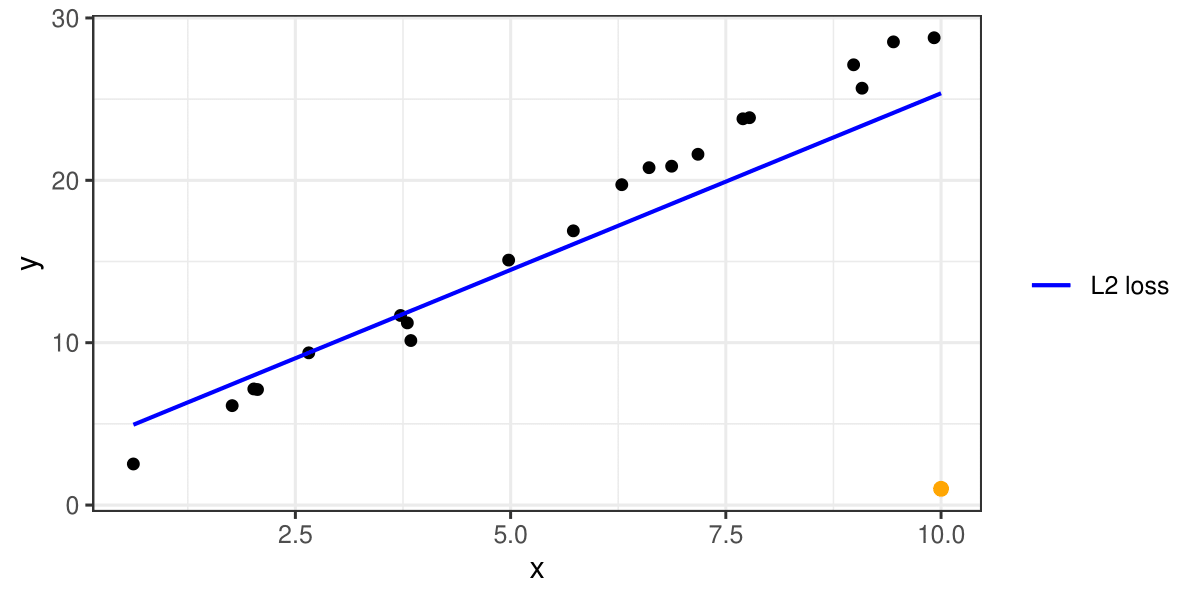

### b)

The Huber loss combines the respective advantages of $L1$ and $L2$ loss: it is smooth and (once) differentiable
like $L2$ but does not punish larger residuals as severely, leading to more robustness. It is simply a (weighted)
piecewise combination of both losses, where $\epsilon$ marks where $L2$ transits to $L1$ loss. The exact definition is:


$$
  L(y, f(\mathbf{x})) = \begin{cases}
    \frac{1}{2}(y - f(\mathbf{x}))^2  & \text{ if } |y - f(\mathbf{x})| \le \epsilon \\
    \epsilon |y - f(\mathbf{x})|-\frac{1}{2}\epsilon^2 \quad & \text{ otherwise }
    \end{cases}, \quad \epsilon > 0
$$

In the plot we can see how the parabolic shape of the loss around $0$ evolves into an absolute-value function at
$|y - f(\mathbf{x})| > \epsilon = 5$.

## Solution 3: Polynomial Regression

### a) 

*Cubic* means degree $3$, so our hypothesis space will look as follows:
$$
\mathcal{H} = \left \{ f(\mathbf{x}| \mathbf{\theta}) = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 |\; (\theta_0, \theta_1, \theta_2, \theta_3)^T \in \mathbb{R}^4 \right \}
$$

### b)

The empirical risk is:

$$
\mathcal{R}_{emp}(\mathbf{\theta})= \sum_{i=1}^{50} \left( y^{(i)} - \left[ \theta_0 + \theta_1 x^{(i)} + \theta_2 \left(x^{(i)}\right)^2 + \theta_3 \left(x^{(i)}\right)^3 \right] \right)^2
$$

### c)

We can find the gradient just as we did for an intermediate
result when we derived the least-squares estimator:
$$
\nabla_{\mathbf{\theta}} \mathcal{R}_{emp}(\mathbf{\theta}) = \frac{\partial}{\partial \mathbf{\theta}} \left \| \mathbf{y} - \mathbf{X}\mathbf{\theta} \right \|_2^2\\
= \frac{\partial}{\partial \mathbf{\theta}} \left( (\mathbf{y} - \mathbf{X}\mathbf{\theta})^T (\mathbf{y} - \mathbf{X}\mathbf{\theta})\right)\\
= -2 \mathbf{X}^T \mathbf{y} + 2 \mathbf{X}^T \mathbf{X} \mathbf{\theta}\\
= 2 \cdot \left( -\mathbf{X}^T \mathbf{y} + \mathbf{X}^T \mathbf{X} \mathbf{\theta} \right)
$$

### d) 

Recall that the idea of gradient descent (*descent!*) is to traverse the risk surface in the direction of the negative
gradient as we are in search for the minimum. Therefore, we will update our current parameter set $\mathbf{\theta}^{[t]}$ with
the negative gradient of the current empirical risk w.r.t. $\mathbf{\theta}$, scaled by learning rate (or step size) $\alpha$:
$$
\mathbf{\theta}^{[t+1]} = \mathbf{\theta}^{[t]} - \alpha \cdot \nabla_{\mathbf{\theta}} \mathcal{R}_{emp}(\mathbf{\theta}^{[t]}) 
$$

Note that the $L2$-induced multiplicative constant of $2$ in the gradient can simply be absorbed by $\tilde{\alpha} := \frac{1}{2} \alpha$:

$$
\underbrace{\mathbf{\theta}^{[t+1]}}_{p \times 1} = \underbrace{\mathbf{\theta}^{[t]}}_{p \times 1} - \tilde{\alpha} \cdot \left( - \underbrace{\mathbf{\tilde{X}}^T}_{p \times n} \underbrace{\mathbf{y}}_{n \times 1} + \underbrace{\mathbf{\tilde{X}}^T \mathbf{\tilde{X}}}_{p \times p} \underbrace{\mathbf{\theta}^{[t]}}_{p \times 1} \right)
$$

$$
\left( \matrix{ \theta_1 \\ \theta_2 \\ \vdots \\ \theta_p} \right)^{[t + 1]} = \left( \matrix{ \theta_1 \\ \theta_2 \\ \vdots \\ \theta_p} \right)^{[t]} - \tilde{\alpha} \cdot \left( - \mathbf{\tilde{X}}^T \mathbf{y} + \mathbf{\tilde{X}}^T \mathbf{\tilde{X}} \left( \matrix{ \theta_1 \\ \theta_2 \\ \vdots \\ \theta_p} \right)^{[t]} \right)
$$

What actually happens here: we update each component of our current parameter vector $\mathbf{\theta}^{[t]}$
in the *direction* of the negative gradient, i.e., following the steepest downward slope, and also by an *amount* that depends on the value of the gradient.


In order to see what that means it is helpful to recall that the gradient $\nabla_{\mathbf{\theta}} \mathcal{R}_{emp}(\mathbf{\theta})$ tells us about the effect (infinitesimally small) changes in $\mathbf{\theta}$ have on $\mathcal{R}_{emp}(\mathbf{\theta})$. A parameter vector component with large gradient has strong impact on the empirical risk, and it is reasonable to assume it to be rather important for the model. <br>
Therefore, gradient updates focus on influential components, and we proceed more quickly along the important
dimensions.

### e) 

We see that, for example, the first model in exercise b) fits the data fairly well but not perfectly. Choosing a
more flexible function (a polynomial of higher degree or a function from an entirely different, more complex,
model class) might be advantageous:
- We would be able to trace the observations more closely if our function were less smooth, and thus reduce empirical risk.

On the other hand, flexibility also has some drawbacks:
- Flexible model classes often have more parameters, making training harder.
- We might run into a phenomenon called **overfitting**. Recall that our ultimate goal is to make predictions on *new* observations (after all, we know the labels for the training data). However, fitting every quirk of the training observations – possibly caused by imprecise measurement or other factors of randomness/error – will not generalize so well to new data.

In the end, we need to balance model fit and generalization. We will discuss the choice of hypotheses quite a
lot since it is one of the most crucial design decisions in machine learning.

### *)  Additional model assessing

There exists no R type regression summary report in sklearn. The main reason is that sklearn is used for predictive modelling / machine learning and the evaluation criteria are based on performance on previously unseen data (such as predictive r^2 for regression).

For the statistical view on Linear Regression you can use the package 

In [18]:
import statsmodels.formula.api as smf

The function OLS performs Ordinary least square fit (Linear regression) and has a summary() function. 

In [19]:
stats_lm = smf.ols('rings ~ longest_shell + whole_weight', data= abalone).fit()
stats_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rings   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     956.9
Date:                Tue, 28 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:54:54   Log-Likelihood:                -10028.
No. Observations:                4177   AIC:                         2.006e+04
Df Residuals:                    4174   BIC:                         2.008e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.4313      0.316     10.873      0.000       2.813       4.050
longest_shell    10.5824      0.907     11.666      0.000       8.804      12.361
whole_weight      1.1550      0.222      5.200      0.000       0.720       1.591
==============================================================================
Omnibus:                     1380.300   Durbin-Watson:                   0.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4440.751
Skew:                           1.687   Prob(JB):                         0.00
Kurtosis:                       6.759   Cond. No.                         34.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the summary function you can retrieve very easily the fitted coefficients and various model metrics based on the model itself and the training data.

Nevertheless, self-defined functions can be used for assessing models from sklearn:

In [20]:
def regression_results(y_true, y_pred):  
    """ 
    Method to produce model metrics for training data
    Input: training response vector as array, prediction vector as array
    Output: -
    """
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('Median Absolut Error: ', round(median_absolute_error,4))

In [21]:
regression_results(y_lm, pred_lm)

explained_variance:  0.3144
mean_squared_log_error:  0.0471
r2:  0.3144
MAE:  1.9507
MSE:  7.1255
RMSE:  2.6694
Median Absolut Error:  1.5254
